In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

In [2]:
data = ert.load("010.dat")
print(data)

Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


In [3]:
data["k"] = ert.geometricFactors(data)
data["rhoa"] = data["r"] * data["k"]
data.estimateError(relativeError=0.02, absoluteError=0.07)

In [4]:
x0 = data.subset(x=0)
x0.setSensors(np.column_stack([pg.y(x0), pg.x(x0)])) # auto for x/y
# x0.show()
print(x0)

Data: Sensors: 14 data: 71, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid']


In [5]:
y1 = data.subset(y=0.6)
y1.setSensors(y1.sensors() * np.array([1, 0, 0]))  # auto
# y1.show()
print(y1)

Data: Sensors: 14 data: 139, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'ya', 'yb', 'ym', 'yn']


In [ ]:
mesh = mt.createParaMesh()

In [48]:
mgr = ert.Manager(y1)
mgr.createMesh(paraDX=0.3, quality=34.4, smooth=True)
mgr.invert(zWeight=0.3, verbose=True)

18/03/24 - 08:58:55 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 08:58:55 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 08:58:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 08:58:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/03/24 - 08:58:56 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1495 Cells: 2832 Boundaries: 2202
18/03/24 - 08:58:56 - pyGIMLi - INFO - Use median(data values)=1195.6100000000017
18/03/24 - 08:58:56 - pyGIMLi - INFO - Created startmodel from forward operator: 370, min/max=1195.610000/1195.610000
18/03/24 - 08:58:56 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000020B365984A0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000020B36598D60>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000020B364ABA00>
min/max (data): 524/2199
min/max (error): 2%/2.01%
min/max (start model): 1196/1196
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  228.65
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   10.37 (dPhi = 95.34%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.49 (dPhi = 91.27%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.49)                   #
################################################################################


370 [1231.6290416013196,...,1236.9188473798877]

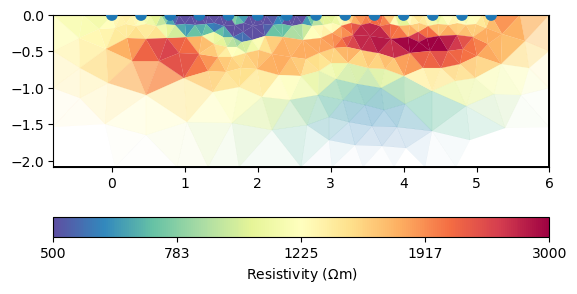

In [49]:
kw = dict(cMin=500, cMax=3000, cMap="Spectral_r", logScale=True)#,
mgr.showResult(**kw);

In [29]:
from pygimli.physics.petro import transFwdArchieS, transInvArchieS

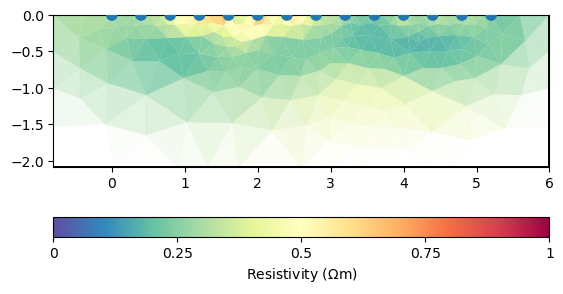

In [51]:
tS = transFwdArchieS(rFluid=66*(1-0.02*20), phi=0.4, m=1.3, n=1.83)
sat = tS.inv(mgr.model)
mgr.showResult(sat, cMin=0, cMax=1, logScale=0);

Detecting small distances, using mm accuracy


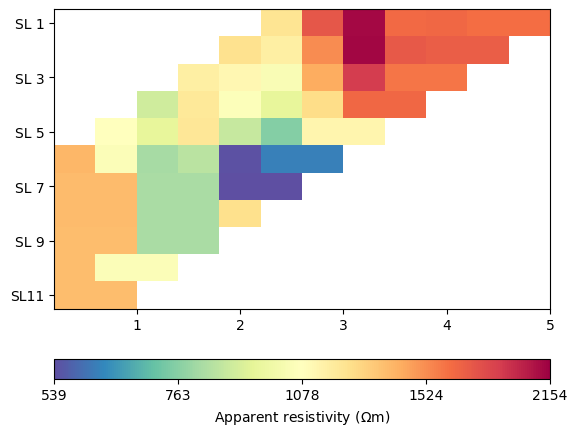

In [52]:
# tS = transFwdArchieS(66*(1-0.02*20), phi=0.4, m=1.3, n=1.83)
fop = pg.frameworks.PetroModelling(mgr.fop, tS)
response = fop.response(sat)
y1.show(response);

In [61]:
fop.setMesh(mgr.paraDomain)
inv = pg.Inversion(fop=fop)
inv.setRegularization(1, background=True)
inv.setRegularization(2, limits=[0, 1])
startModel = pg.Vector(len(sat), 0.2)
model = inv.run(y1["rhoa"], relativeError=y1["err"], startModel=startModel)
mgr.showModel(model)

18/03/24 - 09:04:43 - pyGIMLi - INFO - Found 369 regions.
18/03/24 - 09:04:43 - pyGIMLi - INFO - Region with smallest marker set to background (marker=0)
18/03/24 - 09:04:43 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.convertStartModel(c:\Guenther.T\src\gimli\gimli\pygimli\frameworks\inversion.py:227)
Starting model size invalid 370 != 367.
18/03/24 - 09:04:43 - pyGIMLi - INFO - Use median(data values)=1195.6100000000017
18/03/24 - 09:04:43 - pyGIMLi - INFO - Created startmodel from forward operator: 367, min/max=0.297855/0.297855


RuntimeError: ./core/src/modellingbase.cpp:434		GIMLI::RVector GIMLI::ModellingBase::createMappedModel(const GIMLI::RVector&, double) const  marker >= than model.size() 367 >= 367